In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotnine as pn
import seaborn as sns 

import utils
from sklearn.metrics.pairwise import cosine_similarity, paired_distances
from sklearn import metrics 
from sklearn.preprocessing import StandardScaler, scale
from scipy.spatial import distance

from einops import rearrange, reduce, repeat


In [29]:
import importlib
importlib.reload(utils)


<module 'utils' from '/home/acercyc/projects/Keio Testing_analysis/src/utils.py'>

In [2]:
subjs = utils.ExpInfo.getSubjIDs()
# subj = utils.ExpInfo.getSubjIDs()[0]
task = utils.ExpInfo.taskName[1]


In [49]:
def get_traj_hidden_dist(subj, task):
    # load data
    _, h, _ = utils.LoadData.xhy(subj, task)
    _, h_disp, _ = utils.LoadData.xhy_disp(subj, task)
    df_beh = utils.LoadData.behaviorData(subj, task) 
    
    
    scale1 = StandardScaler().fit(np.concatenate(h, axis=0))
    d = []
    for trial in h_disp:
        for dot in trial:
            d.append(dot)
    d = np.concatenate(d, axis=0)
    scale2 = StandardScaler().fit(d)   
         

    dist_measure = 'euclidean'
    dists = []
    dist_coss = []
    roc_auc = []
    prediction = []
    dist_target = []
    for iTrial in range(len(h_disp)):
        dist_cos = []
        dist = []
        target = df_beh['target dot'][iTrial]-1
        for iDot in range(3):
            h1 = h[iTrial][:-1, :]            
            h2 = h_disp[iTrial][iDot]
            
            h1 = scale1.transform(h1)
            h2 = scale2.transform(h2)
            
            dist_cos_ = cosine_similarity(h1, h2).diagonal()
            dist_ = paired_distances(h1, h2, metric=dist_measure)
            dist_cos.append(dist_cos_)
            dist.append(dist_)
            
        dist = np.vstack(dist).T
        dist_cos = np.vstack(dist_cos).T 
        
        # target dist
        dist_target.append(dist.mean(axis=0)[target])
        
        # predict choise
        prediction.append(np.argmin(dist.mean(axis=0)) + 1)
        
        dists.append(dist)
        dist_coss.append(dist_cos)
        
        # ROC
        y_true = np.zeros(dist.shape)
        
        y_true[:, target] = 1
        # fpr, tpr, thresholds = metrics.roc_curve(y_true.flatten(), 1-dist.flatten())
        fpr, tpr, thresholds = metrics.roc_curve(y_true.flatten(), 1-dist.flatten())
        roc_auc.append(metrics.auc(fpr, tpr))
        
    df_beh_ = df_beh.copy()
    df_beh_['AUC'] = roc_auc
    df_beh_['prediction'] = prediction
    df_beh_['target dist'] = dist_target
    
    return df_beh_

df = utils.GroupOperation.map(get_traj_hidden_dist, subjs, task)
df = pd.concat(df, axis=0)

|████████████████████████████████████████| 50/50 [100%] in 34.4s (1.45/s)                                               


# dist between intention and target

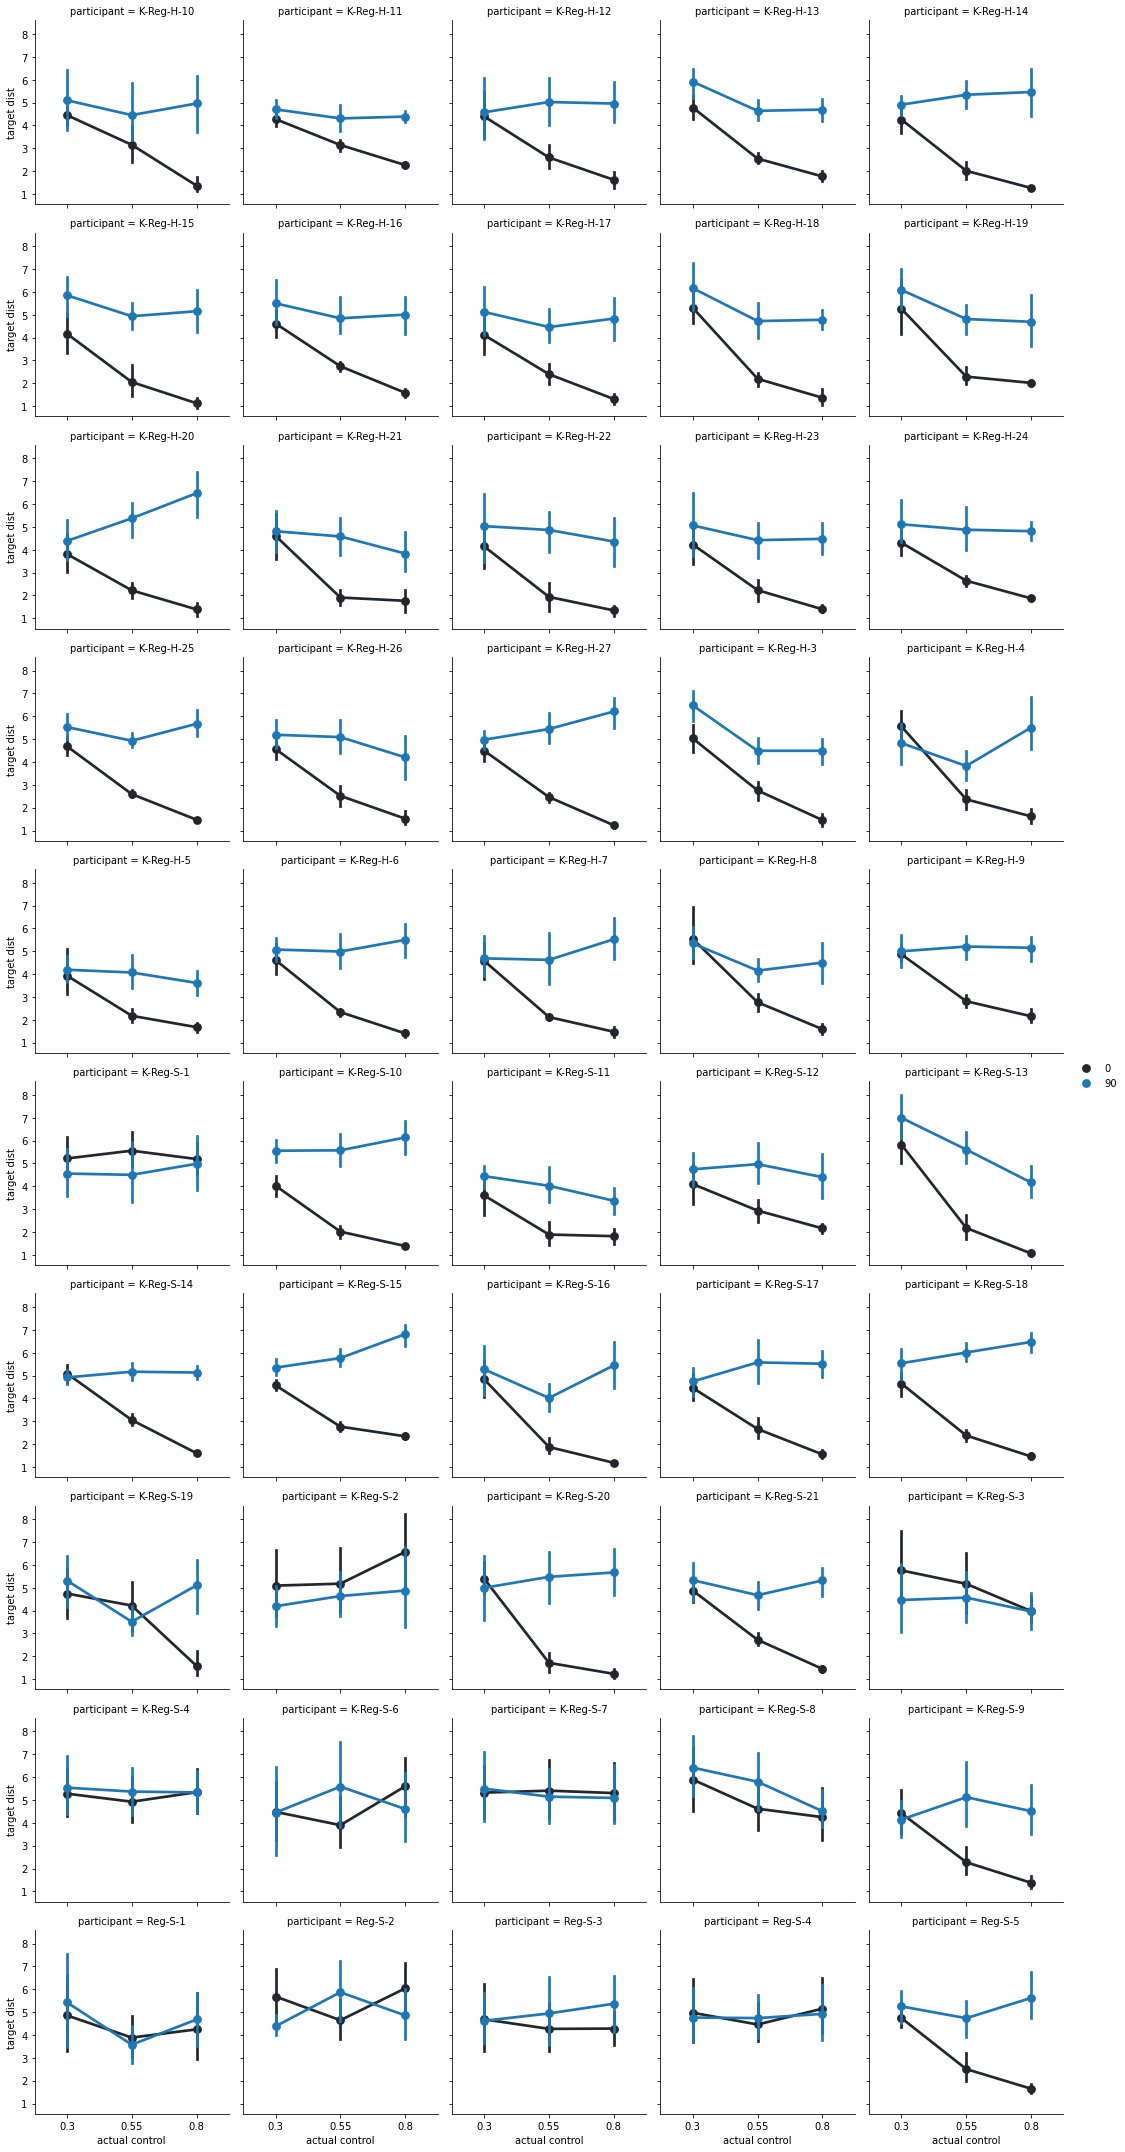

In [51]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='target dist', 
                   hue='angular bias')
grid.add_legend()

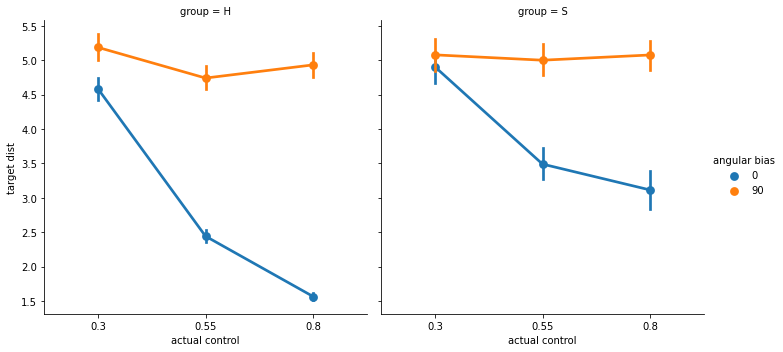

In [52]:
sns.catplot(x='actual control', y='target dist', hue='angular bias', data=df, col='group', kind='point')


# AUC

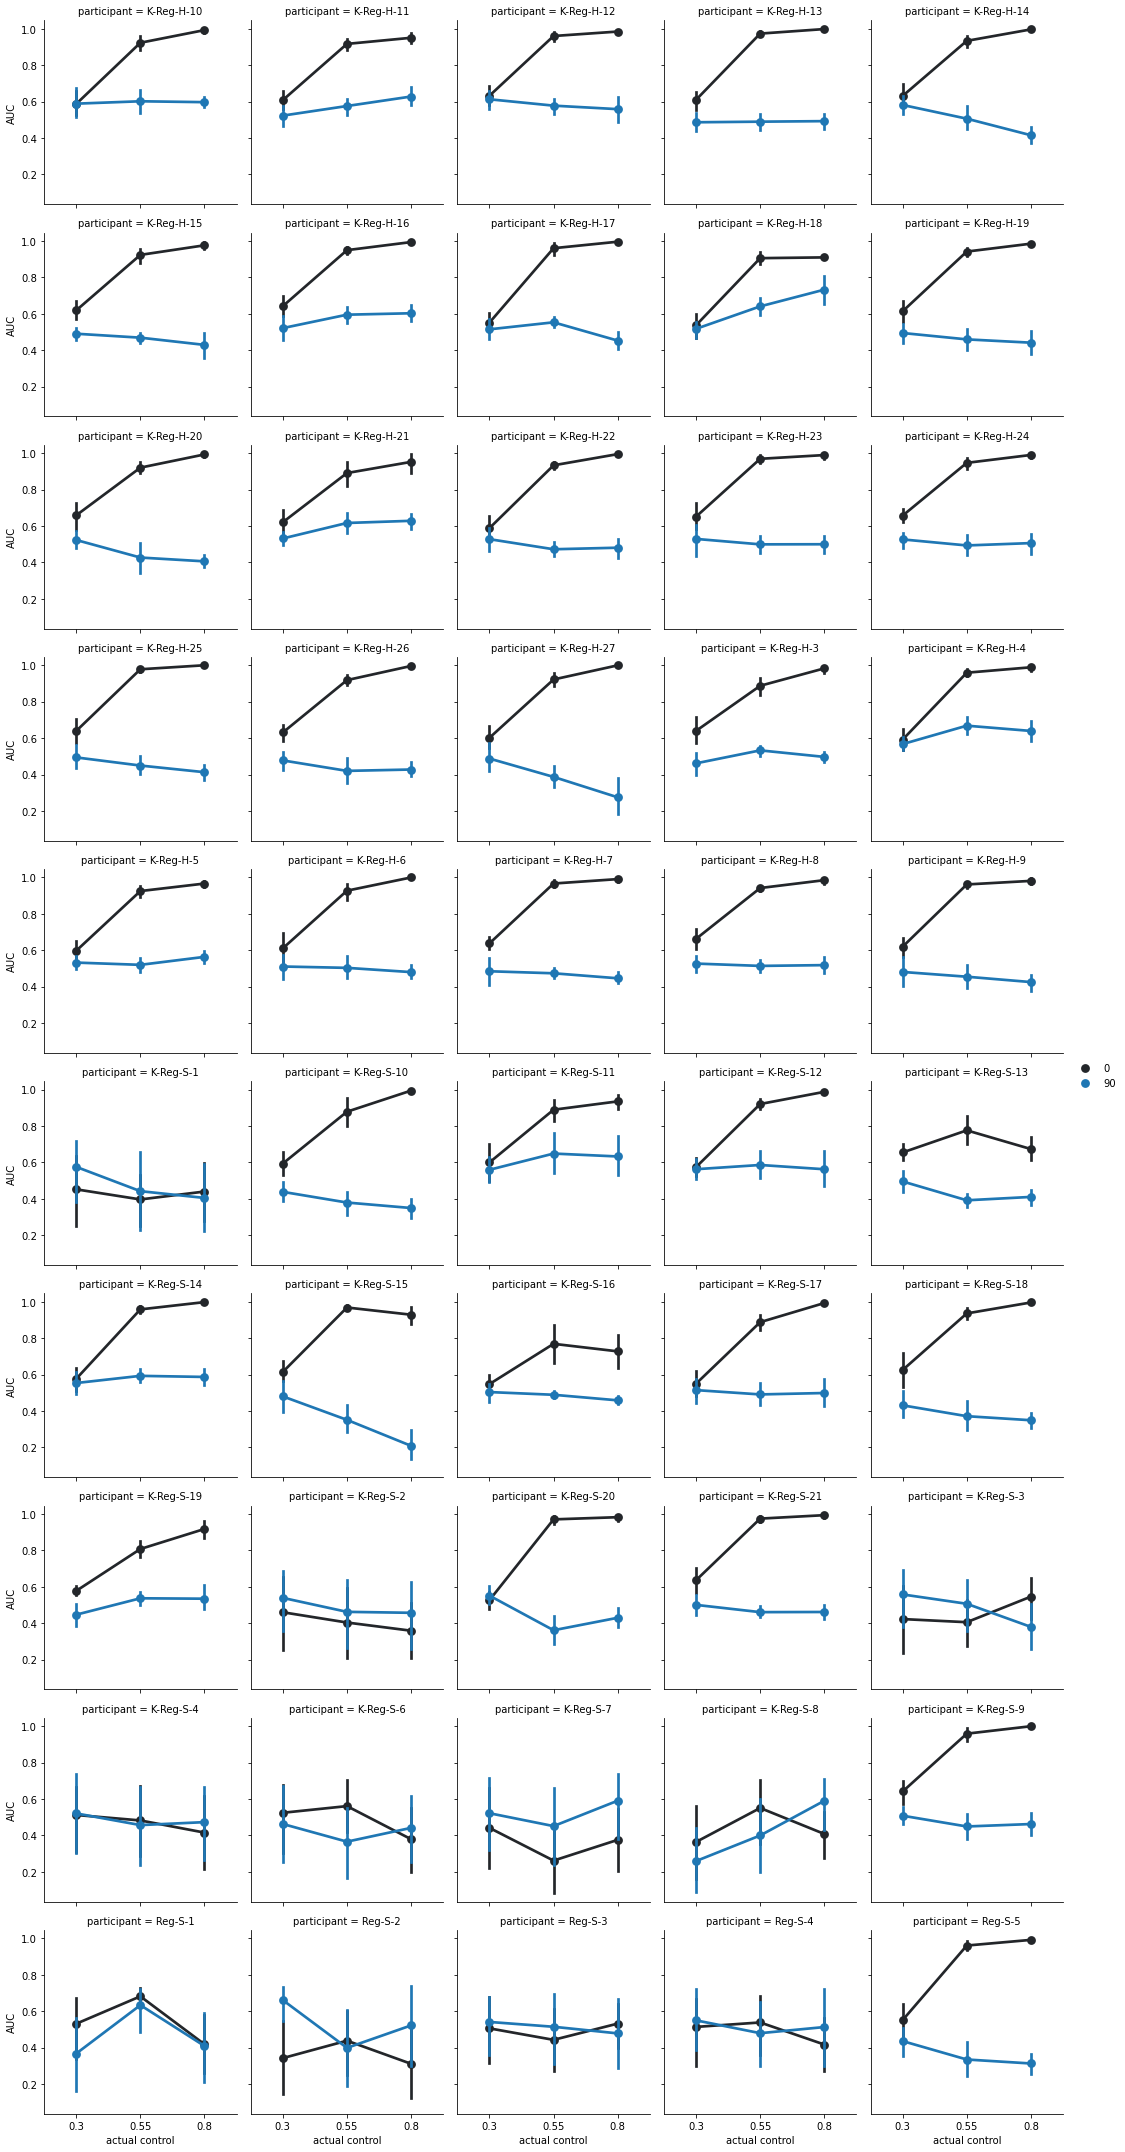

In [53]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='AUC', 
                   hue='angular bias')
grid.add_legend()

# Predict choise from distance

In [57]:
df_ = df.copy()
df_['pred_accuracy'] = df_['prediction'] == df_['selected dot']
df_['pred_accuracy_target'] = df_['prediction'] == df_['target dot']

df_ = df_[['participant', 'actual control', 'angular bias', 'pred_accuracy', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias', 'group']).mean()
df_ = df_.reset_index()

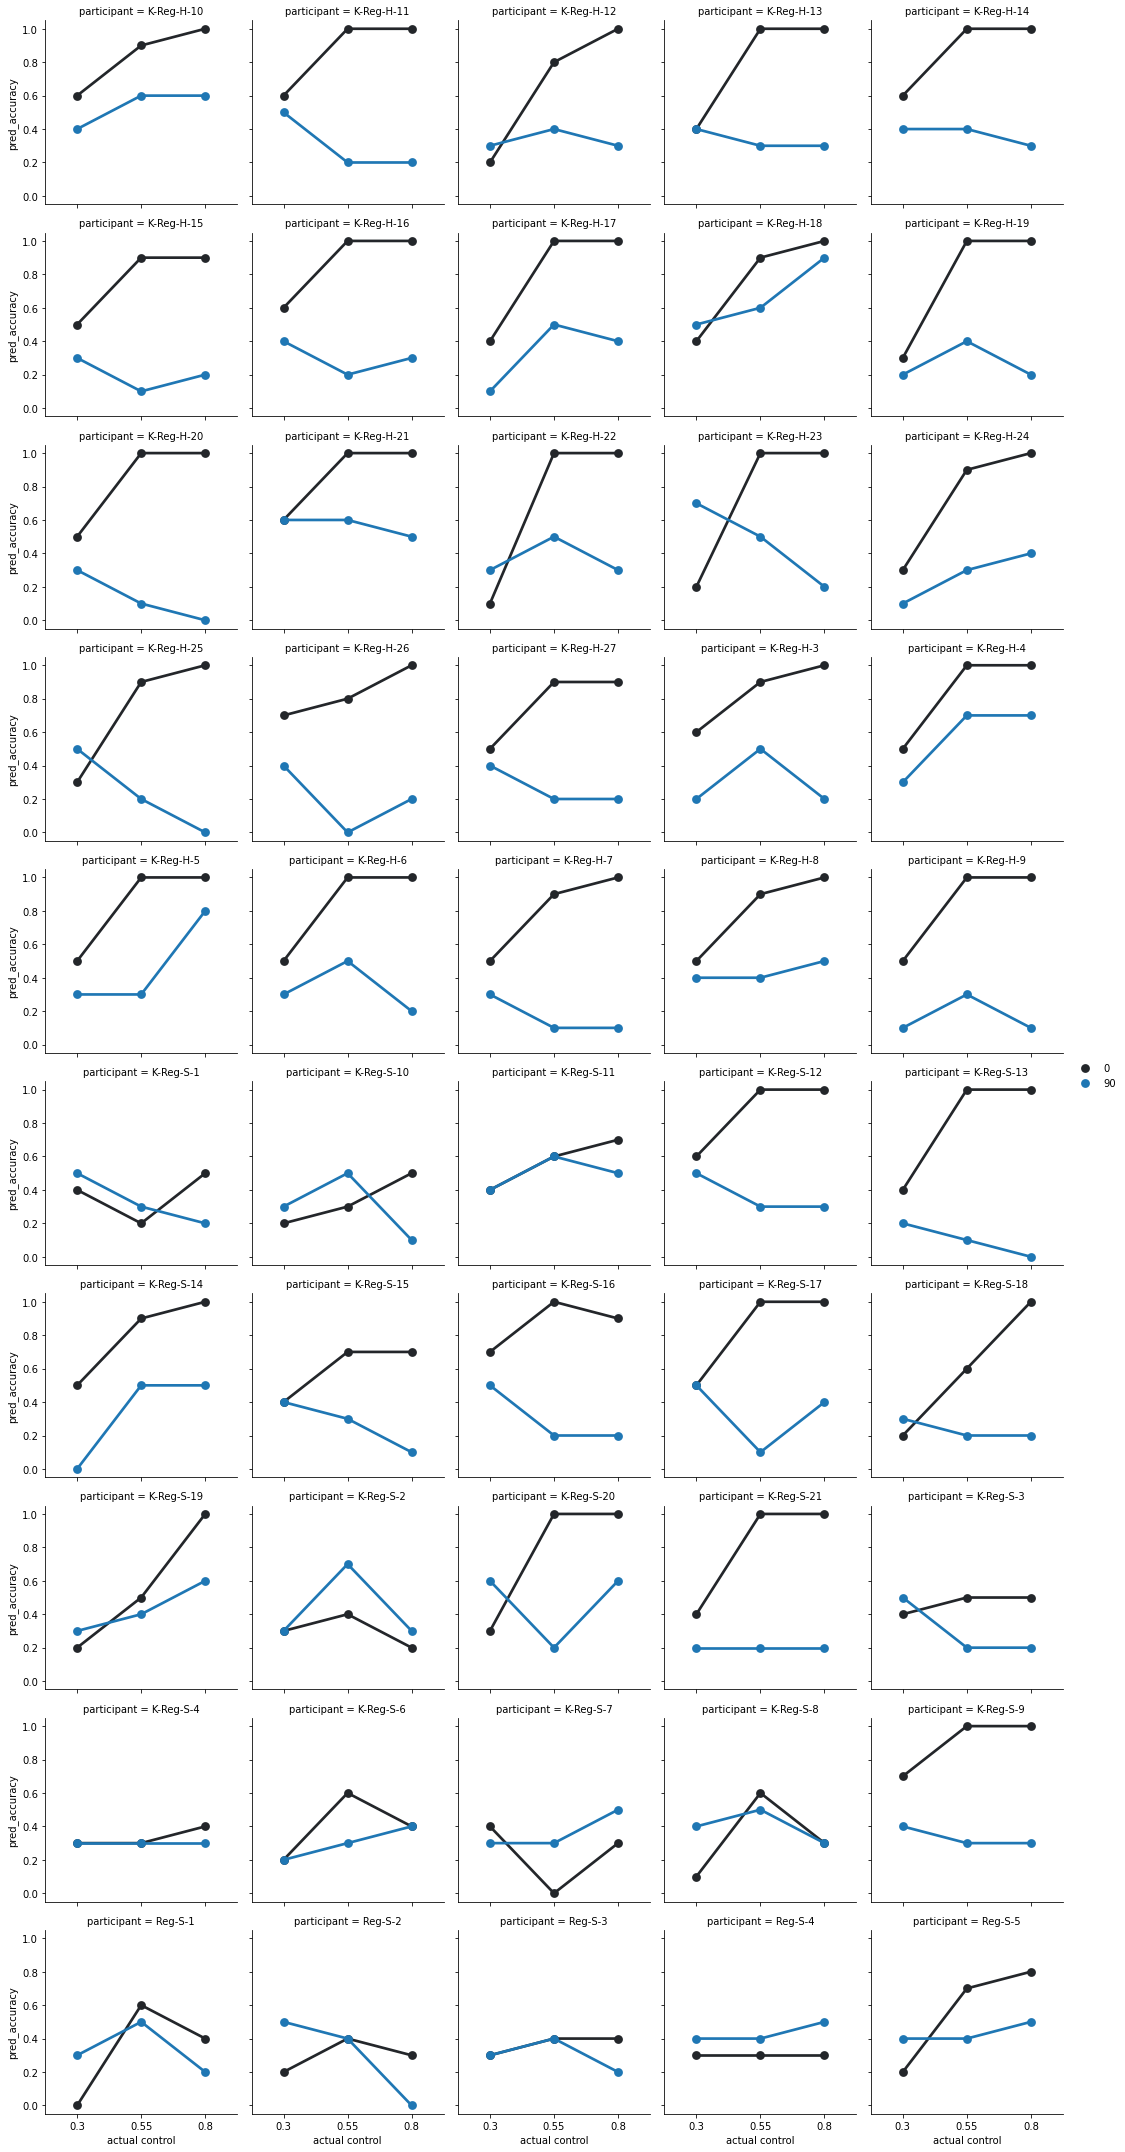

In [55]:
grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='pred_accuracy', 
                   hue='angular bias')
grid.add_legend()

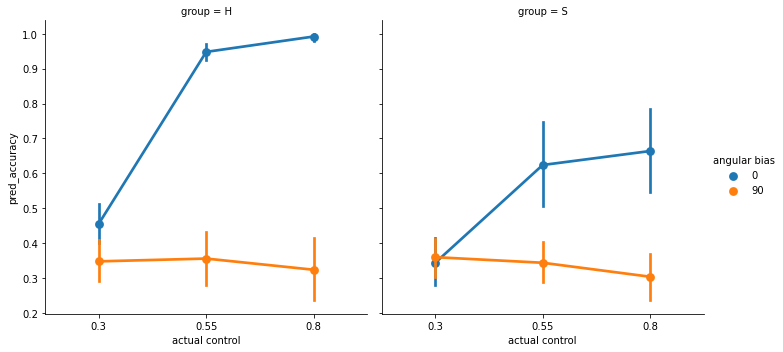

In [58]:
sns.catplot(x='actual control', y='pred_accuracy', hue='angular bias', data=df_, col='group', kind='point')


# Predict target from distance

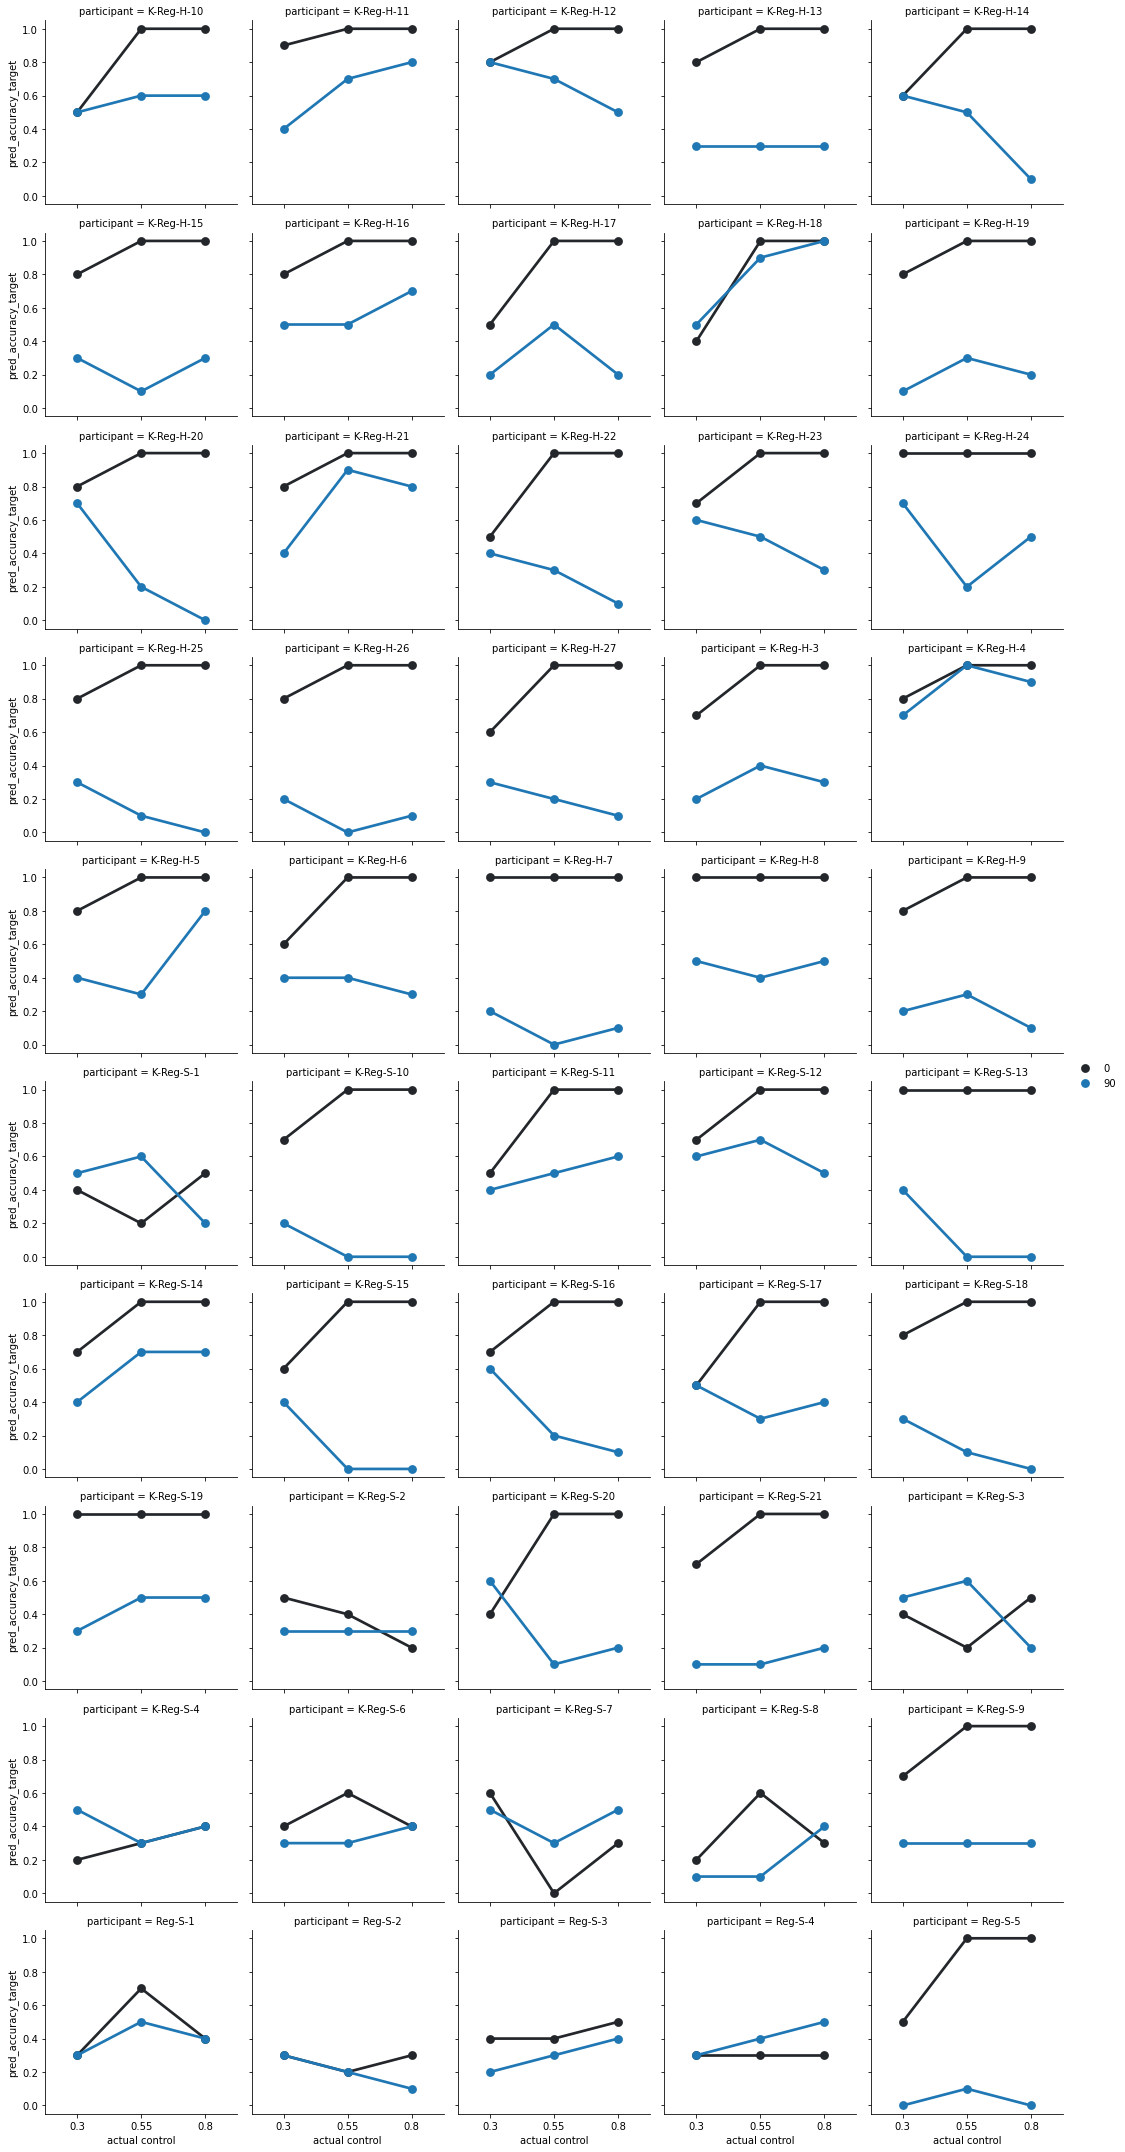

In [59]:
df_ = df.copy()
df_['pred_accuracy'] = df_['prediction'] == df_['selected dot']
df_['pred_accuracy_target'] = df_['prediction'] == df_['target dot']

df_ = df_[['participant', 'actual control', 'angular bias', 'pred_accuracy_target', 'group']]
df_ = df_.groupby(['participant', 'actual control', 'angular bias','group']).mean()
df_ = df_.reset_index()

grid = sns.FacetGrid(col='participant', col_wrap=5, data=df_)
grid.map_dataframe(sns.pointplot, 
                   x='actual control', 
                   y='pred_accuracy_target', 
                   hue='angular bias')
grid.add_legend()

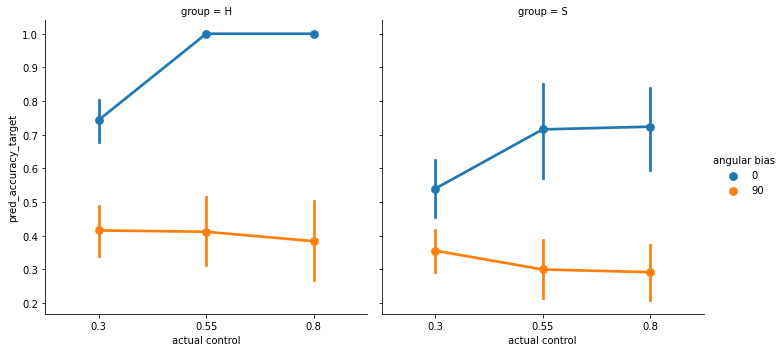

In [60]:
sns.catplot(x='actual control', y='pred_accuracy_target', hue='angular bias', data=df_, col='group', kind='point')
